In [1]:
import torch
import torch.nn as nn
from torch.nn.functional import relu
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.amp import GradScaler
from collections import  Counter
import torch.nn.functional as F
import torch.optim as optim
import gc
from torch.optim import lr_scheduler
import cv2
import copy
import random
import os
from pathlib import Path
import glob
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
import warnings 
warnings.filterwarnings("ignore")

In [2]:
root_path = Path("/kaggle/input/lyft-udacity-challenge")
dirs = ["dataA", "dataB", "dataC", "dataD", "dataE"]

images = []
masks = []

for d in dirs:
    img_path = root_path / d / d / "CameraRGB"
    msk_path = root_path / d / d / "CameraSeg"
    
    if img_path.exists():
        images.extend(sorted(img_path.glob("*.png")))
        masks.extend(sorted(msk_path.glob("*.png")))

print(f"Total images: {len(images)}")
print(f"Total masks: {len(masks)}")

Total images: 5000
Total masks: 5000


In [3]:
df = pd.DataFrame({"image": images, "mask": masks})

In [4]:
df.head()

,image,mask
0,/kaggle/input/lyft-udacity-challenge/dataA/dat...,/kaggle/input/lyft-udacity-challenge/dataA/dat...
1,/kaggle/input/lyft-udacity-challenge/dataA/dat...,/kaggle/input/lyft-udacity-challenge/dataA/dat...
2,/kaggle/input/lyft-udacity-challenge/dataA/dat...,/kaggle/input/lyft-udacity-challenge/dataA/dat...
3,/kaggle/input/lyft-udacity-challenge/dataA/dat...,/kaggle/input/lyft-udacity-challenge/dataA/dat...
4,/kaggle/input/lyft-udacity-challenge/dataA/dat...,/kaggle/input/lyft-udacity-challenge/dataA/dat...


In [5]:
print("Duplicate image paths:", df["image"].duplicated().sum())
print("Duplicate mask paths:", df["mask"].duplicated().sum())

Duplicate image paths: 0
Duplicate mask paths: 0


In [6]:
image_shapes = []
for img_path in df["image"].sample(200, random_state=42):
    img = cv2.imread(img_path)
    image_shapes.append(img.shape)

shape_counts = Counter(image_shapes)
shape_counts

Counter({(600, 800, 3): 200})

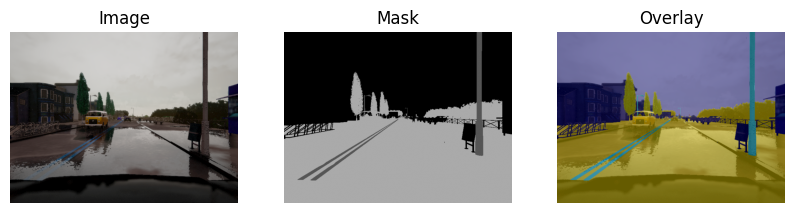

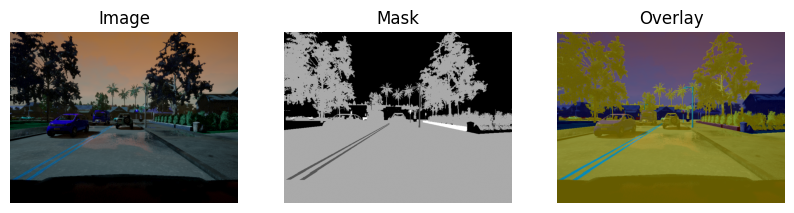

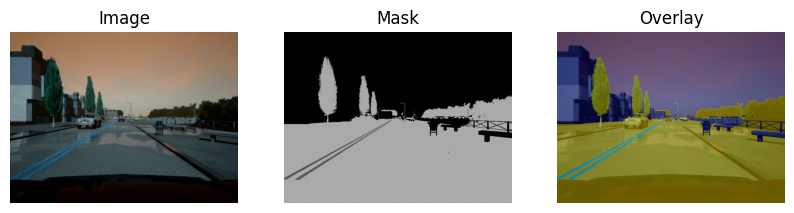

In [7]:
def visualize_sample(img_path, mask_path):
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(10,4))

    plt.subplot(1,3,1)
    plt.title("Image")
    plt.imshow(img)
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Mask")
    plt.imshow(mask, cmap="gray")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Overlay")
    plt.imshow(img, cmap="gray")
    plt.imshow(mask, cmap="jet", alpha=0.4)
    plt.axis("off")

    plt.show()


for idx in random.sample(range(len(df)), 3):
    visualize_sample(df.iloc[idx]["image"], df.iloc[idx]["mask"])

In [8]:
mask_values = set()

for mask_path in df["mask"].sample(200, random_state=42):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask_values.update(np.unique(mask))

sorted(mask_values)

[np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3)]

In [9]:
# Load as RGB to see actual class encoding
mask_path = df["mask"].iloc[0]
mask_rgb = cv2.imread(mask_path, cv2.IMREAD_COLOR)
mask_rgb = cv2.cvtColor(mask_rgb, cv2.COLOR_BGR2RGB)

# Get unique colors
unique_colors = np.unique(mask_rgb.reshape(-1, 3), axis=0)
print(f"Number of unique colors: {len(unique_colors)}")
print("Unique RGB values:")
for color in unique_colors[:10]:
    print(f"  RGB: {color}")

Number of unique colors: 12
Unique RGB values:
  RGB: [0 0 0]
  RGB: [1 0 0]
  RGB: [2 0 0]
  RGB: [3 0 0]
  RGB: [5 0 0]
  RGB: [6 0 0]
  RGB: [7 0 0]
  RGB: [8 0 0]
  RGB: [9 0 0]
  RGB: [10  0  0]


In [10]:
class_ids = set()
for mask_path in df["mask"].sample(200, random_state=42):
    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
    red_channel = mask[:, :, 2] 
    class_ids.update(np.unique(red_channel))

print(f"Total classes: {len(class_ids)}")
print(f"Class IDs: {sorted(class_ids)}")

Total classes: 13
Class IDs: [np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5), np.uint8(6), np.uint8(7), np.uint8(8), np.uint8(9), np.uint8(10), np.uint8(11), np.uint8(12)]


In [11]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussNoise(p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
    ToTensorV2()
])

val_test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

In [12]:
class SegmentationDataset(Dataset):
    def __init__(self, df, transform=None):
        """
        Args:
            df (pd.DataFrame): DataFrame containing "image" and "mask" paths.
            transform (albumentations.Compose): Transformation pipeline.
        """
        self.df = df.reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # 1. Fetch paths
        img_path = str(self.df.iloc[idx]["image"])
        mask_path = str(self.df.iloc[idx]["mask"])
        
        # 2. Read Image (BGR to RGB)
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Could not load image: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
   
        mask_bgr = cv2.imread(mask_path, cv2.IMREAD_COLOR)
        if mask_bgr is None:
            raise ValueError(f"Could not load mask: {mask_path}")
        
        mask = mask_bgr[:, :, 2]
        
        # 4. Apply Transforms
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]
        
        if not isinstance(image, torch.Tensor):
            image = torch.from_numpy(image).permute(2, 0, 1).float()
            
        if not isinstance(mask, torch.Tensor):
            mask = torch.from_numpy(mask).long()
        else:
            mask = mask.long() 
            
        return image, mask

In [13]:
train_val_idx, test_idx = train_test_split(
    range(len(df)), 
    test_size=0.1, 
    random_state=42
)


train_idx, val_idx = train_test_split(
    train_val_idx, 
    test_size=0.2,  
    random_state=42
)


train_df = df.iloc[train_idx].reset_index(drop=True)
val_df = df.iloc[val_idx].reset_index(drop=True)
test_df = df.iloc[test_idx].reset_index(drop=True)

print(f"\nDataset split:")
print(f"Train: {len(train_df)} samples ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation: {len(val_df)} samples ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test: {len(test_df)} samples ({len(test_df)/len(df)*100:.1f}%)")


train_dataset = SegmentationDataset(train_df, transform=train_transform)
val_dataset = SegmentationDataset(val_df, transform=val_test_transform)
test_dataset = SegmentationDataset(test_df, transform=val_test_transform)


Dataset split:
Train: 3600 samples (72.0%)
Validation: 900 samples (18.0%)
Test: 500 samples (10.0%)


In [14]:
class SpatialAttentionModule(nn.Module):
    def __init__(self, kernel_size):
        super(SpatialAttentionModule, self).__init__()
        assert kernel_size in (3, 7), "kernel size must be 3 or 7"
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)

    def forward(self, x):
        avg_pool = torch.mean(x, dim=1, keepdim=True)
        max_pool, _ = torch.max(x, dim=1, keepdim=True)
        cat_out = torch.cat([avg_pool, max_pool], dim=1)
        out = self.conv(cat_out)
        M = torch.sigmoid(out)
        return x * M

In [15]:
class SEBlock(nn.Module):
  def __init__(self, in_channels, reduction=16):
    super(SEBlock, self).__init__()
    reduced = max(1, in_channels // reduction)
    self.avg_global_pooling = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Conv2d(in_channels, reduced, 1)
    self.relu = nn.ReLU(inplace=True)
    self.fc_out = nn.Conv2d(reduced, in_channels, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    avg_pooling = self.avg_global_pooling(x)
    fc1 = self.fc(avg_pooling)
    relu = self.relu(fc1)
    fc2 = self.fc_out(relu)
    sigmoid = self.sigmoid(fc2)
    return x * sigmoid

In [16]:
class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = SEBlock(in_channels, reduction)
        self.spatial_attention = SpatialAttentionModule(kernel_size)

    def forward(self, x):
      x = self.channel_attention.forward(x)
      x = self.spatial_attention.forward(x)
      return x

In [17]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_p=0.2):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(p=dropout_p)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = relu(x)
        x = self.dropout(x)
        return x

class UNet(nn.Module):
    def __init__(self, n_classes, use_cbam=True, dropout_p=0.2):  
        super(UNet, self).__init__()
        self.use_cbam = use_cbam
        
        # ENCODER PART
        self.enc1_1 = ConvBlock(3, 64, dropout_p=dropout_p)
        self.enc1_2 = ConvBlock(64, 64, dropout_p=dropout_p)
        self.cbam_enc1 = CBAM(64, reduction=16) if use_cbam else None
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc2_1 = ConvBlock(64, 128, dropout_p=dropout_p)
        self.enc2_2 = ConvBlock(128, 128, dropout_p=dropout_p)
        self.cbam_enc2 = CBAM(128, reduction=16) if use_cbam else None
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc3_1 = ConvBlock(128, 256, dropout_p=dropout_p)
        self.enc3_2 = ConvBlock(256, 256, dropout_p=dropout_p)
        self.cbam_enc3 = CBAM(256, reduction=16) if use_cbam else None
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc4_1 = ConvBlock(256, 512, dropout_p=dropout_p)
        self.enc4_2 = ConvBlock(512, 512, dropout_p=dropout_p)
        self.cbam_enc4 = CBAM(512, reduction=16) if use_cbam else None
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # BOTTLENECK with higher dropout
        self.bottleneck1 = ConvBlock(512, 1024, dropout_p=dropout_p * 1.5)
        self.bottleneck2 = ConvBlock(1024, 1024, dropout_p=dropout_p * 1.5)
        self.cbam_bottleneck = CBAM(1024, reduction=16) if use_cbam else None
        
        # DECODER PART
        self.up1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec1_1 = ConvBlock(1024, 512, dropout_p=dropout_p)
        self.dec1_2 = ConvBlock(512, 512, dropout_p=dropout_p)
        self.cbam_dec1 = CBAM(512, reduction=16) if use_cbam else None
        
        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec2_1 = ConvBlock(512, 256, dropout_p=dropout_p)
        self.dec2_2 = ConvBlock(256, 256, dropout_p=dropout_p)
        self.cbam_dec2 = CBAM(256, reduction=16) if use_cbam else None
        
        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec3_1 = ConvBlock(256, 128, dropout_p=dropout_p)
        self.dec3_2 = ConvBlock(128, 128, dropout_p=dropout_p)
        self.cbam_dec3 = CBAM(128, reduction=16) if use_cbam else None
        
        self.up4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec4_1 = ConvBlock(128, 64, dropout_p=dropout_p)
        self.dec4_2 = ConvBlock(64, 64, dropout_p=dropout_p)
        self.cbam_dec4 = CBAM(64, reduction=16) if use_cbam else None

        self.out = nn.Conv2d(64, n_classes, 1)
        
    def forward(self, x):
        # ENCODER PART
        xe11 = self.enc1_1(x)
        xe12 = self.enc1_2(xe11)
        if self.use_cbam:
            xe12 = self.cbam_enc1(xe12)
        pool1 = self.pool1(xe12)
        
        xe21 = self.enc2_1(pool1)
        xe22 = self.enc2_2(xe21)
        if self.use_cbam:
            xe22 = self.cbam_enc2(xe22)
        pool2 = self.pool2(xe22)
        
        xe31 = self.enc3_1(pool2)
        xe32 = self.enc3_2(xe31)
        if self.use_cbam:
            xe32 = self.cbam_enc3(xe32)
        pool3 = self.pool3(xe32)
        
        xe41 = self.enc4_1(pool3)
        xe42 = self.enc4_2(xe41)
        if self.use_cbam:
            xe42 = self.cbam_enc4(xe42)
        pool4 = self.pool4(xe42)
        
        # BOTTLENECK
        xe51 = self.bottleneck1(pool4)
        xe52 = self.bottleneck2(xe51)
        if self.use_cbam:
            xe52 = self.cbam_bottleneck(xe52)
        
        # DECODER PART
        xu1 = self.up1(xe52)
        xu1 = torch.cat((xu1, xe42), dim=1)  # skip connection
        xu11 = self.dec1_1(xu1)
        xu12 = self.dec1_2(xu11)
        if self.use_cbam:
            xu12 = self.cbam_dec1(xu12)
        
        xu2 = self.up2(xu12)
        xu2 = torch.cat((xu2, xe32), dim=1)  # skip connection
        xu21 = self.dec2_1(xu2)
        xu22 = self.dec2_2(xu21)
        if self.use_cbam:
            xu22 = self.cbam_dec2(xu22)
        
        xu3 = self.up3(xu22)
        xu3 = torch.cat((xu3, xe22), dim=1)  # skip connection
        xu31 = self.dec3_1(xu3)
        xu32 = self.dec3_2(xu31)
        if self.use_cbam:
            xu32 = self.cbam_dec3(xu32)
        
        xu4 = self.up4(xu32)
        xu4 = torch.cat((xu4, xe12), dim=1)  # skip connection
        xu41 = self.dec4_1(xu4)
        xu42 = self.dec4_2(xu41)
        if self.use_cbam:
            xu42 = self.cbam_dec4(xu42)
        
        out = self.out(xu42)
        return out

In [18]:
def multiclass_dice_loss(pred, target, num_classes, smooth=1e-6):
    """Multi-class Dice loss"""
    pred = F.softmax(pred, dim=1)  
    
    dice_loss = 0
    for class_idx in range(num_classes):
        pred_class = pred[:, class_idx]
        target_class = (target == class_idx).float()
        
        pred_flat = pred_class.reshape(-1)
        target_flat = target_class.reshape(-1)
        
        intersection = (pred_flat * target_flat).sum()
        union = pred_flat.sum() + target_flat.sum()
        
        dice = (2. * intersection + smooth) / (union + smooth)
        dice_loss += (1 - dice)
    
    return dice_loss / num_classes

@torch.no_grad()
def multiclass_dice_score(pred, target, num_classes, smooth=1e-6):
    """Multi-class Dice score"""
    pred = torch.argmax(pred, dim=1)  
    
    dice_scores = []
    for class_idx in range(num_classes):
        pred_class = (pred == class_idx).float()
        target_class = (target == class_idx).float()
        
        intersection = (pred_class * target_class).sum()
        union = pred_class.sum() + target_class.sum()
        
        if union == 0:
            continue  
            
        dice = (2. * intersection + smooth) / (union + smooth)
        dice_scores.append(dice)
    
    return torch.tensor(dice_scores).mean()

@torch.no_grad()
def calculate_miou(pred, target, num_classes):
    """Mean Intersection over Union"""
    pred = torch.argmax(pred, dim=1)
    
    ious = []
    for class_idx in range(num_classes):
        pred_class = (pred == class_idx)
        target_class = (target == class_idx)
        
        intersection = (pred_class & target_class).sum().float()
        union = (pred_class | target_class).sum().float()
        
        if union == 0:
            continue
            
        iou = intersection / union
        ious.append(iou)
    
    return torch.tensor(ious).mean() if ious else torch.tensor(0.0)

In [19]:
class Trainer:
    def __init__(self, model, num_classes=13, patience=7, class_weights=None):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.num_classes = num_classes

        self.batch_size = 16
        self.accumulation_steps = 2
        
        # Early Stopping
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.best_model_wts = copy.deepcopy(model.state_dict())

        self.scaler = GradScaler()

        # Multi-class loss with optional class weights
        if class_weights is not None:
            class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.device)
        self.ce_loss = nn.CrossEntropyLoss(weight=class_weights)
        
        # Optimizer
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-4, weight_decay=1e-5)

        # Scheduler
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=3
        )

    def combined_loss(self, outputs, targets):
        """Combined CrossEntropy + Dice Loss for multi-class segmentation"""
        ce = self.ce_loss(outputs, targets)
        dice = multiclass_dice_loss(outputs, targets, num_classes=self.num_classes)
        return 0.5 * ce + 0.5 * dice

    def get_loader(self, dataset, shuffle=True):
        return DataLoader(
            dataset,
            batch_size=self.batch_size,
            shuffle=shuffle,
            num_workers=2,
            pin_memory=True,
            persistent_workers=True
        )

    def clean_memory(self):
        gc.collect()
        torch.cuda.empty_cache()

    def train_epoch(self, data_loader, epoch_idx):
        self.model.train()
        loss_total = 0.0

        self.optimizer.zero_grad(set_to_none=True)
        loop = tqdm(data_loader, desc=f"Epoch {epoch_idx+1} [Train]", leave=False)

        for batch_idx, (data, target) in enumerate(loop):
            data = data.to(self.device, non_blocking=True)
            target = target.to(self.device, non_blocking=True).long()

            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                output = self.model(data)
                loss = self.combined_loss(output, target)
                loss = loss / self.accumulation_steps

            self.scaler.scale(loss).backward()

            if (batch_idx + 1) % self.accumulation_steps == 0:
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad(set_to_none=True)

            loss_val = loss.item() * self.accumulation_steps
            loss_total += loss_val
            loop.set_postfix(loss=loss_val)

        if len(data_loader) % self.accumulation_steps != 0:
            self.scaler.step(self.optimizer)
            self.scaler.update()
            self.optimizer.zero_grad(set_to_none=True)
        
        self.clean_memory()

        avg_loss = loss_total / len(data_loader)
        print(f"Epoch {epoch_idx + 1} | Train Loss: {avg_loss:.4f}")
        return avg_loss

    @torch.no_grad()
    def validate_epoch(self, data_loader, epoch_idx):
        self.model.eval()

        val_loss = 0.0
        val_dice = 0.0
        val_miou = 0.0

        loop = tqdm(data_loader, desc=f"Epoch {epoch_idx+1} [Val]", leave=False)

        for data, target in loop:
            data = data.to(self.device, non_blocking=True)
            target = target.to(self.device, non_blocking=True).long()

            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                output = self.model(data)
                loss = self.combined_loss(output, target)

            val_loss += loss.item()
            val_dice += multiclass_dice_score(output, target, self.num_classes).item()
            val_miou += calculate_miou(output, target, self.num_classes).item()

        val_loss /= len(data_loader)
        val_dice /= len(data_loader)
        val_miou /= len(data_loader)

        self.clean_memory()

        current_lr = self.optimizer.param_groups[0]['lr']
        print(
            f"Epoch {epoch_idx + 1} | "
            f"Val Loss: {val_loss:.4f} | "
            f"Val Dice: {val_dice:.4f} | "
            f"Val mIoU: {val_miou:.4f} | "
            f"LR: {current_lr:.6f}"
        )

        self.scheduler.step(val_loss)

        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_wts = copy.deepcopy(self.model.state_dict())
            torch.save(self.model.state_dict(), 'best_model.pth')
            print("  -> New best model saved!")
        else:
            self.counter += 1
            print(f"  -> EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

        return val_loss, val_dice, val_miou

    def fit(self, train_loader, val_loader, epochs):
        for epoch in range(epochs):
            self.train_epoch(train_loader, epoch)
            self.validate_epoch(val_loader, epoch)
            
            if self.early_stop:
                print("Early stopping triggered.")
                self.model.load_state_dict(self.best_model_wts)
                break

        self.clean_memory()   

In [20]:
model = UNet(n_classes=13, use_cbam=True, dropout_p=0.2)


trainer = Trainer(model, num_classes=13, patience=7)


train_loader = trainer.get_loader(train_dataset, shuffle=True)
val_loader = trainer.get_loader(val_dataset, shuffle=False)

trainer.fit(train_loader, val_loader, epochs=50)

Epoch 1 | Train Loss: 1.5106


Epoch 1 | Val Loss: 1.3079 | Val Dice: 0.2182 | Val mIoU: 0.1915 | LR: 0.000100
  -> New best model saved!


Epoch 2 | Train Loss: 1.2243


Epoch 2 | Val Loss: 1.1000 | Val Dice: 0.2800 | Val mIoU: 0.2369 | LR: 0.000100
  -> New best model saved!


Epoch 3 | Train Loss: 1.0342


Epoch 3 | Val Loss: 0.9238 | Val Dice: 0.3204 | Val mIoU: 0.2845 | LR: 0.000100
  -> New best model saved!


Epoch 4 | Train Loss: 0.8880


Epoch 4 | Val Loss: 0.7831 | Val Dice: 0.3672 | Val mIoU: 0.3200 | LR: 0.000100
  -> New best model saved!


Epoch 5 | Train Loss: 0.7887


Epoch 5 | Val Loss: 0.6949 | Val Dice: 0.3876 | Val mIoU: 0.3434 | LR: 0.000100
  -> New best model saved!


Epoch 6 | Train Loss: 0.7106


Epoch 6 | Val Loss: 0.6107 | Val Dice: 0.4071 | Val mIoU: 0.3673 | LR: 0.000100
  -> New best model saved!


Epoch 7 | Train Loss: 0.6476


Epoch 7 | Val Loss: 0.5387 | Val Dice: 0.4187 | Val mIoU: 0.3833 | LR: 0.000100
  -> New best model saved!


Epoch 8 | Train Loss: 0.5948


Epoch 8 | Val Loss: 0.4976 | Val Dice: 0.4681 | Val mIoU: 0.4224 | LR: 0.000100
  -> New best model saved!


Epoch 9 | Train Loss: 0.5572


Epoch 9 | Val Loss: 0.4645 | Val Dice: 0.4841 | Val mIoU: 0.4412 | LR: 0.000100
  -> New best model saved!


Epoch 10 | Train Loss: 0.5228


Epoch 10 | Val Loss: 0.4328 | Val Dice: 0.4895 | Val mIoU: 0.4488 | LR: 0.000100
  -> New best model saved!


Epoch 11 | Train Loss: 0.4990


Epoch 11 | Val Loss: 0.4105 | Val Dice: 0.4946 | Val mIoU: 0.4567 | LR: 0.000100
  -> New best model saved!


Epoch 12 | Train Loss: 0.4832


Epoch 12 | Val Loss: 0.3982 | Val Dice: 0.5014 | Val mIoU: 0.4606 | LR: 0.000100
  -> New best model saved!


Epoch 13 | Train Loss: 0.4638


Epoch 13 | Val Loss: 0.3828 | Val Dice: 0.5458 | Val mIoU: 0.4911 | LR: 0.000100
  -> New best model saved!


Epoch 14 | Train Loss: 0.4473


Epoch 14 | Val Loss: 0.3628 | Val Dice: 0.5698 | Val mIoU: 0.5133 | LR: 0.000100
  -> New best model saved!


Epoch 15 | Train Loss: 0.4324


Epoch 15 | Val Loss: 0.3499 | Val Dice: 0.5827 | Val mIoU: 0.5230 | LR: 0.000100
  -> New best model saved!


Epoch 16 | Train Loss: 0.4197


Epoch 16 | Val Loss: 0.3359 | Val Dice: 0.6057 | Val mIoU: 0.5416 | LR: 0.000100
  -> New best model saved!


Epoch 17 | Train Loss: 0.4046


Epoch 17 | Val Loss: 0.3217 | Val Dice: 0.6210 | Val mIoU: 0.5548 | LR: 0.000100
  -> New best model saved!


Epoch 18 | Train Loss: 0.3972


Epoch 18 | Val Loss: 0.3126 | Val Dice: 0.6307 | Val mIoU: 0.5648 | LR: 0.000100
  -> New best model saved!


Epoch 19 | Train Loss: 0.3835


Epoch 19 | Val Loss: 0.3004 | Val Dice: 0.6420 | Val mIoU: 0.5760 | LR: 0.000100
  -> New best model saved!


Epoch 20 | Train Loss: 0.3717


Epoch 20 | Val Loss: 0.2925 | Val Dice: 0.6481 | Val mIoU: 0.5824 | LR: 0.000100
  -> New best model saved!


Epoch 21 | Train Loss: 0.3662


Epoch 21 | Val Loss: 0.2874 | Val Dice: 0.6518 | Val mIoU: 0.5868 | LR: 0.000100
  -> New best model saved!


Epoch 22 | Train Loss: 0.3585


Epoch 22 | Val Loss: 0.2811 | Val Dice: 0.6559 | Val mIoU: 0.5916 | LR: 0.000100
  -> New best model saved!


Epoch 23 | Train Loss: 0.3545


Epoch 23 | Val Loss: 0.2783 | Val Dice: 0.6584 | Val mIoU: 0.5936 | LR: 0.000100
  -> New best model saved!


Epoch 24 | Train Loss: 0.3465


Epoch 24 | Val Loss: 0.2710 | Val Dice: 0.6718 | Val mIoU: 0.6041 | LR: 0.000100
  -> New best model saved!


Epoch 25 | Train Loss: 0.3404


Epoch 25 | Val Loss: 0.2650 | Val Dice: 0.6819 | Val mIoU: 0.6115 | LR: 0.000100
  -> New best model saved!


Epoch 26 | Train Loss: 0.3373


Epoch 26 | Val Loss: 0.2588 | Val Dice: 0.6920 | Val mIoU: 0.6199 | LR: 0.000100
  -> New best model saved!


Epoch 27 | Train Loss: 0.3339


Epoch 27 | Val Loss: 0.2537 | Val Dice: 0.6971 | Val mIoU: 0.6246 | LR: 0.000100
  -> New best model saved!


Epoch 28 | Train Loss: 0.3271


Epoch 28 | Val Loss: 0.2542 | Val Dice: 0.6971 | Val mIoU: 0.6242 | LR: 0.000100
  -> EarlyStopping counter: 1 out of 7


Epoch 29 | Train Loss: 0.3206


Epoch 29 | Val Loss: 0.2467 | Val Dice: 0.7038 | Val mIoU: 0.6314 | LR: 0.000100
  -> New best model saved!


Epoch 30 | Train Loss: 0.3165


Epoch 30 | Val Loss: 0.2412 | Val Dice: 0.7095 | Val mIoU: 0.6380 | LR: 0.000100
  -> New best model saved!


Epoch 31 | Train Loss: 0.3133


Epoch 31 | Val Loss: 0.2407 | Val Dice: 0.7101 | Val mIoU: 0.6384 | LR: 0.000100
  -> New best model saved!


Epoch 32 | Train Loss: 0.3079


Epoch 32 | Val Loss: 0.2377 | Val Dice: 0.7132 | Val mIoU: 0.6417 | LR: 0.000100
  -> New best model saved!


Epoch 33 | Train Loss: 0.3040


Epoch 33 | Val Loss: 0.2355 | Val Dice: 0.7150 | Val mIoU: 0.6436 | LR: 0.000100
  -> New best model saved!


Epoch 34 | Train Loss: 0.3017


Epoch 34 | Val Loss: 0.2314 | Val Dice: 0.7188 | Val mIoU: 0.6481 | LR: 0.000100
  -> New best model saved!


Epoch 35 | Train Loss: 0.2980


Epoch 35 | Val Loss: 0.2306 | Val Dice: 0.7199 | Val mIoU: 0.6488 | LR: 0.000100
  -> New best model saved!


Epoch 36 | Train Loss: 0.2951


Epoch 36 | Val Loss: 0.2266 | Val Dice: 0.7242 | Val mIoU: 0.6534 | LR: 0.000100
  -> New best model saved!


Epoch 37 | Train Loss: 0.2930


Epoch 37 | Val Loss: 0.2231 | Val Dice: 0.7356 | Val mIoU: 0.6614 | LR: 0.000100
  -> New best model saved!


Epoch 38 | Train Loss: 0.2892


Epoch 38 | Val Loss: 0.2193 | Val Dice: 0.7466 | Val mIoU: 0.6680 | LR: 0.000100
  -> New best model saved!


Epoch 39 | Train Loss: 0.2887


Epoch 39 | Val Loss: 0.2125 | Val Dice: 0.7551 | Val mIoU: 0.6758 | LR: 0.000100
  -> New best model saved!


Epoch 40 | Train Loss: 0.2832


Epoch 40 | Val Loss: 0.2079 | Val Dice: 0.7639 | Val mIoU: 0.6829 | LR: 0.000100
  -> New best model saved!


Epoch 41 | Train Loss: 0.2779


Epoch 41 | Val Loss: 0.2011 | Val Dice: 0.7721 | Val mIoU: 0.6907 | LR: 0.000100
  -> New best model saved!


Epoch 42 | Train Loss: 0.2723


Epoch 42 | Val Loss: 0.1981 | Val Dice: 0.7748 | Val mIoU: 0.6939 | LR: 0.000100
  -> New best model saved!


Epoch 43 | Train Loss: 0.2676


Epoch 43 | Val Loss: 0.1996 | Val Dice: 0.7716 | Val mIoU: 0.6906 | LR: 0.000100
  -> EarlyStopping counter: 1 out of 7


Epoch 44 | Train Loss: 0.2646


Epoch 44 | Val Loss: 0.1945 | Val Dice: 0.7796 | Val mIoU: 0.6985 | LR: 0.000100
  -> New best model saved!


Epoch 45 | Train Loss: 0.2625


Epoch 45 | Val Loss: 0.1892 | Val Dice: 0.7862 | Val mIoU: 0.7059 | LR: 0.000100
  -> New best model saved!


Epoch 46 | Train Loss: 0.2554


Epoch 46 | Val Loss: 0.1885 | Val Dice: 0.7865 | Val mIoU: 0.7066 | LR: 0.000100
  -> New best model saved!


Epoch 47 | Train Loss: 0.2540


Epoch 47 | Val Loss: 0.1873 | Val Dice: 0.7882 | Val mIoU: 0.7082 | LR: 0.000100
  -> New best model saved!


Epoch 48 | Train Loss: 0.2530


Epoch 48 | Val Loss: 0.1852 | Val Dice: 0.7907 | Val mIoU: 0.7113 | LR: 0.000100
  -> New best model saved!


Epoch 49 | Train Loss: 0.2490


Epoch 49 | Val Loss: 0.1855 | Val Dice: 0.7907 | Val mIoU: 0.7113 | LR: 0.000100
  -> EarlyStopping counter: 1 out of 7


Epoch 50 | Train Loss: 0.2467


Epoch 50 | Val Loss: 0.1811 | Val Dice: 0.7957 | Val mIoU: 0.7174 | LR: 0.000100
  -> New best model saved!


In [21]:
def test_model(model, test_loader, num_classes, model_path='best_model.pth'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # 1. Load the best weights
    print(f"Loading weights from {model_path}...")
    checkpoint = torch.load(model_path, map_location=device)
    
    # If you used the dictionary sav|e method from the previous step:
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
        
    model.eval()
    
    test_dice = 0.0
    test_miou = 0.0
    
    print("Starting Evaluation...")
    with torch.no_grad():
        # Use autocast if you trained with mixed precision
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            for data, target in tqdm(test_loader, desc="Testing"):
                data = data.to(device, non_blocking=True)
                target = target.to(device, non_blocking=True).long()
                
                output = model(data)
                
                # Calculate metrics using your existing functions
                test_dice += multiclass_dice_score(output, target, num_classes).item()
                test_miou += calculate_miou(output, target, num_classes).item()
                
    # 2. Calculate Averages
    avg_dice = test_dice / len(test_loader)
    avg_miou = test_miou / len(test_loader)
    
    print("\n" + "="*30)
    print("FINAL TEST RESULTS")
    print(f"Mean Dice Score: {avg_dice:.4f}")
    print(f"Mean IoU (mIoU): {avg_miou:.4f}")
    print("="*30)
    
    return avg_dice, avg_miou

In [22]:
def visualize_prediction(model, dataset, idx=0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    
    # Get data
    image, mask = dataset[idx] # image: [C, H, W], mask: [H, W]
    
    # Prepare input for model: add batch dimension [1, C, H, W]
    input_tensor = image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(input_tensor)
        # Convert output to class predictions
        pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
        
    # Plotting
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    # Un-normalize image if you used Normalize transform
    # (assuming standard ImageNet mean/std)
    img_show = image.permute(1, 2, 0).numpy()
    img_show = (img_show * 0.229) + 0.485 
    plt.imshow(np.clip(img_show, 0, 1))
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask.numpy(), cmap='jet')
    plt.title("Ground Truth")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(pred, cmap='jet')
    plt.title("Model Prediction")
    plt.axis('off')
    
    plt.show()

In [23]:
test_loader = DataLoader(
            test_dataset,
            batch_size = 4,
            shuffle = False,
        )

In [24]:
avg_dice, avg_miou = test_model(model, test_loader, num_classes=13)


avg_dice, avg_miou

Loading weights from best_model.pth...
Starting Evaluation...


Testing: 100%|██████████| 125/125 [00:24<00:00,  5.15it/s]


FINAL TEST RESULTS
Mean Dice Score: 0.7993
Mean IoU (mIoU): 0.7218


(0.7993014869689942, 0.7217582221031189)

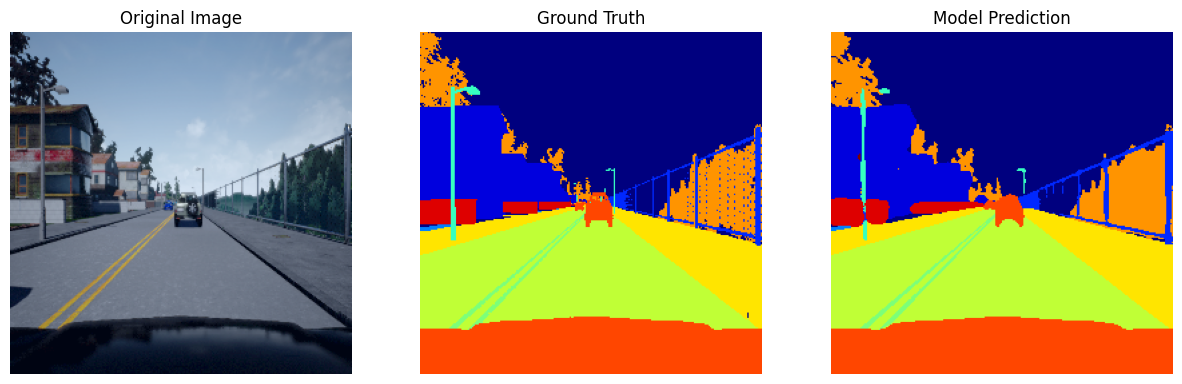

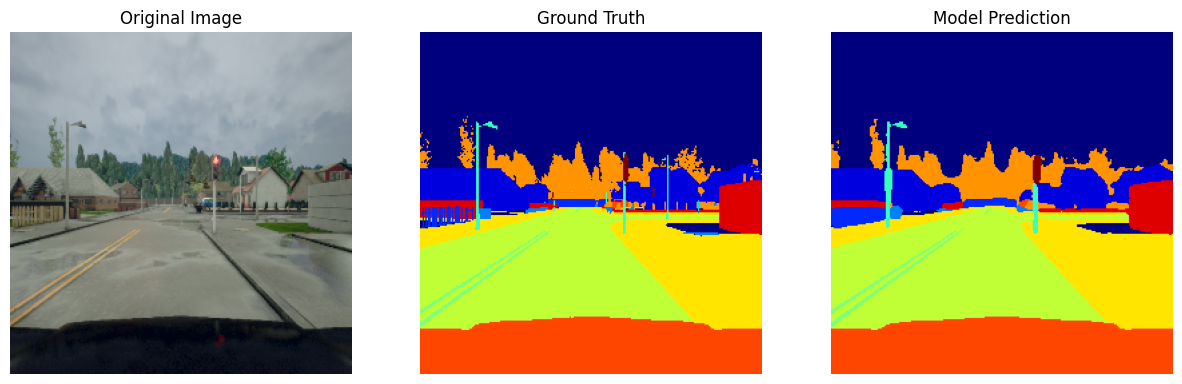

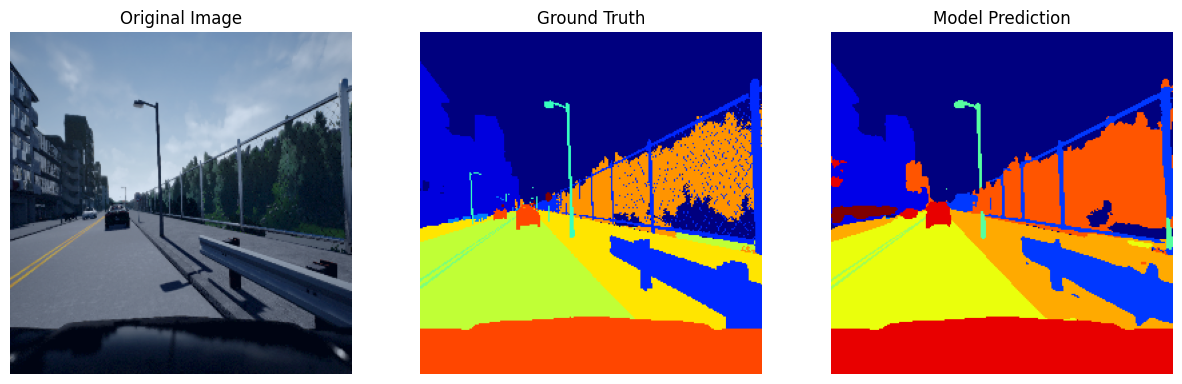

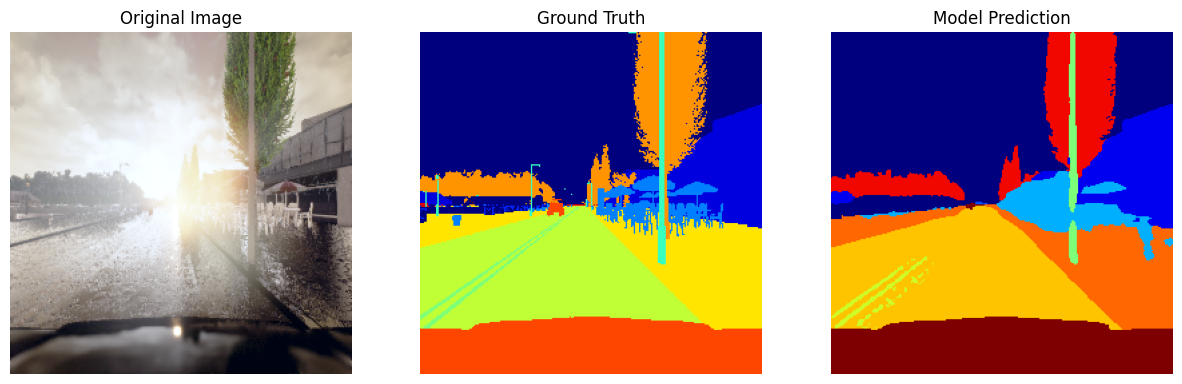

In [25]:
visualize_prediction(model, test_dataset, idx=10)
visualize_prediction(model, test_dataset, idx=50)
visualize_prediction(model, test_dataset, idx=40)
visualize_prediction(model, test_dataset, idx=20)